# Sistemas Cognitivos Artificiales - Laboratorio 3
## Integrantes del grupo:

- Sergio Manuel 

# Laboratorio: Modelos del lenguaje con RNNs

En este laboratorio, vamos a entrenar un modelo del lenguaje basado en caracteres con Recurrent Neural Networks. Asimismo, utilizaremos el modelo para generar texto. En particular, alimentaremos nuestro modelo con obras de la literatura clásica en castellano para obtener una red neuronal que sea capaz de "escribir" fragmentos literarios.

Los entrenamientos en esta laboratorio para obtener un modelo de calidad podrían tomar cierto tiempo (5-10 minutos por epoch), por lo que se aconseja empezar a trabajar pronto. El uso de GPUs no ayuda tanto con LSTMs como con CNNs, por lo que si tenéis máquinas potentes en casa es posible que podáis entrenar más rápido o a la misma velocidad que en Colab. En todo caso, la potencia de Colab es más que suficiente para completar este laboratorio con éxito.

<center><img src="https://upload.wikimedia.org/wikipedia/commons/d/d8/El_ingenioso_hidalgo_don_Quijote_de_la_Mancha.jpg" style="text-align: center" height="300px"></center>

El dataset a utilizar consistirá en un archivo de texto con el contenido íntegro en castellano antiguo de El Ingenioso Hidalgo Don Quijote de la Mancha, disponible de manera libre en la página de [Project Gutenberg](https://www.gutenberg.org). Asimismo, como apartado optativo en este laboratorio se pueden utilizar otras fuentes de texto. Aquí podéis descargar los datos a utilizar de El Quijote y un par de obras adicionales:

[El ingenioso hidalgo Don Quijote de la Mancha (Miguel de Cervantes)](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219424&authkey=AH0gb-qSo5Xd7Io)

[Compilación de obras teatrales (Calderón de la Barca)](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219433&authkey=AKvGD6DC3IRBqmc)

[Trafalgar (Benito Pérez Galdós)](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219434&authkey=AErPCAtMKOI5tYQ)

Como ya deberíamos de estar acostumbrados en problemas de Machine Learning, es importante echar un vistazo a los datos antes de empezar.

## 1. Carga y procesado del texto

Primero, vamos a descargar el libro e inspeccionar los datos. El fichero a descargar es una versión en .txt del libro de Don Quijote, a la cual se le han borrado introducciones, licencias y otras secciones para dejarlo con el contenido real de la novela.

In [1]:
import numpy as np 
import keras
import matplotlib.pyplot as plt
from keras.callbacks import LambdaCallback
from keras.models import Sequential

from keras.models import Model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Input


import random
import io

import os, sys

Using TensorFlow backend.


In [2]:
# Bajamos los archivos
path = keras.utils.get_file(
    fname="don_quijote.txt", 
    origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219424&authkey=AH0gb-qSo5Xd7Io"
)

path = keras.utils.get_file(
    fname="Trafalgar.txt", 
    origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219434&authkey=AErPCAtMKOI5tYQ"
)

Una vez descargado, vamos a leer el contenido del fichero en una variable. Adicionalmente, convertiremos el contenido del texto a minúsculas para ponérselo un poco más fácil a nuestro modelo (de modo que todas las letras sean minúsculas y el modelo no necesite diferenciar entre minúsculas y mayúsculas).

**1.1.** Leer todo el contenido del fichero en una única variable ***text*** y convertir el string a minúsculas

In [3]:
if os.name == 'nt':
    file_path = os.path.join(os.path.expanduser('~') + r'\.keras\datasets', 'don_quijote.txt')
else:
    file_path = os.path.join(os.path.expanduser('~') + '/.keras/datasets', 'don_quijote.txt')
    
with open(file_path, 'r', encoding='utf-8') as f:
    text = f.read()

# convierto a minúsculas
text = text.lower()

Podemos comprobar ahora que efectivamente nuestra variable contiene el resultado deseado, con el comienzo tan característico del Quijote.

In [4]:
print("Longitud del texto: {}".format(len(text)))
print(text[0:300])

Longitud del texto: 2071198
capítulo primero. que trata de la condición y ejercicio del famoso hidalgo
don quijote de la mancha


en un lugar de la mancha, de cuyo nombre no quiero acordarme, no ha mucho
tiempo que vivía un hidalgo de los de lanza en astillero, adarga antigua,
rocín flaco y galgo corredor. una olla de algo más


## 2. Procesado de los datos

Una de las grandes ventajas de trabajar con modelos que utilizan caracteres en vez de palabras es que no necesitamos tokenizar el texto (partirlo palabra a palabra). Nuestro modelo funcionará directamente con los caracteres en el texto, incluyendo espacios, saltos de línea, etc.

Antes de hacer nada, necesitamos procesar el texto en entradas y salidas compatibles con nuestro modelo. Como sabemos, un modelo del lenguaje con RNNs acepta una serie de caracteres y predice el siguiente carácter en la secuencia.

* "*El ingenioso don Qui*" -> predicción: **j**
* "*El ingenioso don Quij*" -> predicción: **o**

De modo que la entrada y la salida de nuestro modelo necesita ser algo parecido a este esquema. En este punto, podríamos usar dos formas de preparar los datos para nuestro modelo.

1. **Secuencia a secuencia**. La entrada de nuestro modelo sería una secuencia y la salida sería esa secuencia trasladada un caracter a la derecha, de modo que en cada instante de tiempo la RNN tiene que predecir el carácter siguiente. Por ejemplo:

>* *Input*:   El ingenioso don Quijot 
>* *Output*: l ingenioso don Quijote

2. **Secuencia a carácter**. En este variante, pasaríamos una secuencia de caracteres por nuestra RNN y, al llegar al final de la secuencia, predeciríamos el siguiente carácter.

>* *Input*:   El ingenioso don Quijot 
>* *Output*: e

En este laboratorio, por simplicidad, vamos a utilizar la segunda variante.

De este modo, a partir del texto, hemos de generar nuestro propio training data que consista en secuencias de caracteres con el siguiente carácter a predecir. Para estandarizar las cosas, utilizaremos secuencias de tamaño *SEQ_LENGTH* caracteres (un hiperparámetro que podemos elegir nosotros).



#### 2.1. Obtención de los caracteres y mapas de caracteres

Antes que nada, necesitamos saber qué caracteres aparecen en el texto, ya que tendremos que diferenciarlos mediante un índice de 0 a *num_chars* - 1 en el modelo. Obtener:
 

1.   Número de caracteres únicos que aparecen en el texto.
2.   Diccionario que asocia char a índice único entre 0 y *num_chars* - 1. Por ejemplo, {'a': 0, 'b': 1, ...}
3.   Diccionario reverso de índices a caracteres: {0: 'a', 1: 'b', ...}


In [5]:
# Busco los caracteres:
caracter_v = []
for c in text:
    if c not in caracter_v:
        caracter_v.append(c)
caracter_v.sort()

print(' - Se encontraron {:d} caracteres: {}'.format(len(caracter_v), caracter_v) )


# Armamos los diccionarios correspondientes.
idx_v = list(range(len(caracter_v)))
chr2idx_d = dict(zip(caracter_v, idx_v))
idx2chr_d = dict(zip(idx_v, caracter_v))

print(' - chr2idx_d = ', chr2idx_d)
print(' - idx2chr_d = ', idx2chr_d)

 - Se encontraron 61 caracteres: ['\n', ' ', '!', '"', "'", '(', ')', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', ':', ';', '?', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '¡', '«', '»', '¿', 'à', 'á', 'é', 'í', 'ï', 'ñ', 'ó', 'ù', 'ú', 'ü']
 - chr2idx_d =  {'\n': 0, ' ': 1, '!': 2, '"': 3, "'": 4, '(': 5, ')': 6, ',': 7, '-': 8, '.': 9, '0': 10, '1': 11, '2': 12, '3': 13, '4': 14, '5': 15, '6': 16, '7': 17, ':': 18, ';': 19, '?': 20, ']': 21, 'a': 22, 'b': 23, 'c': 24, 'd': 25, 'e': 26, 'f': 27, 'g': 28, 'h': 29, 'i': 30, 'j': 31, 'l': 32, 'm': 33, 'n': 34, 'o': 35, 'p': 36, 'q': 37, 'r': 38, 's': 39, 't': 40, 'u': 41, 'v': 42, 'w': 43, 'x': 44, 'y': 45, 'z': 46, '¡': 47, '«': 48, '»': 49, '¿': 50, 'à': 51, 'á': 52, 'é': 53, 'í': 54, 'ï': 55, 'ñ': 56, 'ó': 57, 'ù': 58, 'ú': 59, 'ü': 60}
 - idx2chr_d =  {0: '\n', 1: ' ', 2: '!', 3: '"', 4: "'", 5: '(', 6: ')', 7: ',', 8: '-', 9: '.', 10: '

#### 2.2. Obtención de secuencias de entrada y carácter a predecir

Ahora, vamos a obtener las secuencias de entrada en formato texto y los correspondientes caracteres a predecir. Para ello, recorrer el texto completo leído anteriormente, obteniendo una secuencia de SEQ_LENGTH caracteres y el siguiente caracter a predecir. Una vez hecho, desplazarse un carácter a la izquierda y hacer lo mismo para obtener una nueva secuencia y predicción. Guardar las secuencias en una variable ***sequences*** y los caracteres a predecir en una variable ***next_chars***.

Por ejemplo, si el texto fuera "Don Quijote" y SEQ_LENGTH fuese 5, tendríamos

* *sequences* = ["Don Q", "on Qu", "n Qui", " Quij", "Quijo", "uijot"]
* *next_chars* = ['u', 'i', 'j', 'o', 't', 'e']

In [5]:
# Definimos el tamaño de las secuencias. Puedes dejar este valor por defecto.
SEQ_LENGTH = 30

sequences = []
next_chars = []

for i in range(0, len(text) - SEQ_LENGTH - 1):
    sequences.append(  text[i:i+SEQ_LENGTH] )
    next_chars.append( text[i+SEQ_LENGTH]   )
    
assert len(sequences) == len(next_chars), 'ERROR, armaste mal las sequencias'

Indicar el tamaño del training set que acabamos de generar.

In [6]:
print(' Cantidad de secuencias armadas = ', len(sequences))

 Cantidad de secuencias armadas =  2071167


Como el Quijote es muy largo y tenemos muchas secuencias, podríamos encontrar problemas de memoria. Por ello, vamos a elegir un número máximo de ellas. Si estás corriendo esto localmente y tienes problemas de memoria, puedes reducir el tamaño aún más, pero ten cuidado porque, a menos datos, peor calidad del modelo.

In [7]:
MAX_SEQUENCES = 500000

perm = np.random.permutation(len(sequences))
sequences, next_chars = np.array(sequences), np.array(next_chars)
sequences, next_chars = sequences[perm], next_chars[perm]
sequences, next_chars = list(sequences[:MAX_SEQUENCES]), list(next_chars[:MAX_SEQUENCES])

print(len(sequences))

500000


#### 2.3. Obtención de input X y output y para el modelo

Finalmente, a partir de los datos de entrenamiento que hemos generado vamos a crear los arrays de datos X e y que pasaremos a nuestro modelo.

Para ello, vamos a utilizar *one-hot encoding* para nuestros caracteres. Por ejemplo, si sólo tuviéramos 4 caracteres (a, b, c, d), las representaciones serían: (1, 0, 0, 0), (0, 1, 0, 0), (0, 0, 1, 0) y (0, 0, 0, 1).

De este modo, **X** tendrá shape *(num_sequences, seq_length, num_chars)* e **y** tendrá shape *(num_sequences, num_chars)*. 



In [8]:
NUM_CHARS = len(chr2idx_d)
NUM_SEQUENCES = len(sequences)
X = np.zeros((NUM_SEQUENCES, SEQ_LENGTH, NUM_CHARS), dtype=np.int8)
y = np.zeros((NUM_SEQUENCES, NUM_CHARS),             dtype=np.int8)

for i_s in range(NUM_SEQUENCES):
    for i_c in range(SEQ_LENGTH):
        X[i_s, i_c, chr2idx_d[sequences[i_s][i_c]]] = 1.0
    
    y[i_s, chr2idx_d[next_chars[i_s]]] = 1.0

assert all([(np.array( [chr2idx_d[a]  for a in sequences[i_s]] ) == np.argmax(X[i_s], axis=-1)).all() for i_s in range(0, NUM_SEQUENCES, NUM_SEQUENCES//100)]), 'ERROR, armaste mal X'

## 3. Definición del modelo y entrenamiento

Una vez tenemos ya todo preparado, es hora de definir el modelo. Define un modelo que utilice una **LSTM** con **128 unidades internas**. Si bien el modelo puede definirse de una manera más compleja, para empezar debería bastar con una LSTM más una capa Dense con el *softmax* que predice el siguiente caracter a producir. Adam puede ser una buena elección de optimizador.

Una vez el modelo esté definido, entrénalo un poco para asegurarte de que la loss es decreciente. No es necesario guardar la salida de este entrenamiento en el entregable final, ya que vamos a hacer el entrenamiento más informativo en el siguiente punto.

In [44]:
def build_model(input_shape, n_output=61, lr=1.e-3):
    # Creamos un modelo Sequential simple solamente con una capa LSTM de 128 unidades y una salida softmax
    model = keras.Sequential()
    model.add( keras.layers.InputLayer(input_shape=input_shape))
    model.add( keras.layers.LSTM(128, return_sequences=False))
    model.add( keras.layers.Dense(n_output, activation='softmax') )
    
    # Utilizamos el optimizador Adam
    opt = keras.optimizers.Adam(lr=lr)
    
    # Ajustamos por crossentropy, y evaluamos el accuracy como métrica
    model.compile(opt, 'categorical_crossentropy', metrics=['categorical_accuracy'])
    
    model.summary()
    return model
                  
input_shape = X.shape[1:]
n_output    = y.shape[-1]

keras.backend.clear_session()
model = build_model(input_shape, n_output, lr=1e-3)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               97280     
_________________________________________________________________
dense_1 (Dense)              (None, 61)                7869      
Total params: 105,149
Trainable params: 105,149
Non-trainable params: 0
_________________________________________________________________


Para ver cómo evoluciona nuestro modelo del lenguaje, vamos a generar texto según va entrenando. Para ello, vamos a programar una función que, utilizando el modelo en su estado actual, genere texto, con la idea de ver cómo se va generando texto al entrenar cada epoch.

En el código de abajo podemos ver una función auxiliar para obtener valores de una distribución multinomial. Esta función se usará para muestrear el siguiente carácter a utilizar según las probabilidades de la salida de softmax (en vez de tomar directamente el valor con la máxima probabilidad, obtenemos un valor aleatorio según la distribución de probabilidad dada por softmax, de modo que nuestros resultados serán más diversos, pero seguirán teniendo "sentido" ya que el modelo tenderá a seleccionar valores con más probabilidad).



In [5]:
def sample(probs, temperature=1.0):
    """Nos da el índice del elemento a elegir según la distribución
    de probabilidad dada por probs.
    
    Args:
      probs es la salida dada por una capa softmax:
        probs = model.predict(x_to_predict)[0]
      
      temperature es un parámetro que nos permite obtener mayor
        "diversidad" a la hora de obtener resultados. 
        
        temperature = 1 nos da la distribución normal de softmax
        0 < temperature < 1 hace que el sampling sea más conservador,
          de modo que sampleamos cosas de las que estamos más seguros
        temperature > 1 hace que los samplings sean más atrevidos,
          eligiendo en más ocasiones clases con baja probabilidad.
          Con esto, tenemos mayor diversidad pero se cometen más
          errores.
    """
    # Cast a float64 por motivos numéricos
    probs = np.asarray(probs).astype('float64')
    
    # Hacemos logaritmo de probabilidades y aplicamos reducción
    # por temperatura.
    probs = np.log(probs) / temperature
    
    # Volvemos a aplicar exponencial y normalizamos de nuevo
    exp_probs = np.exp(probs)
    probs = exp_probs / np.sum(exp_probs)
    
    # Hacemos el sampling dadas las nuevas probabilidades
    # de salida (ver doc. de np.random.multinomial)
    samples = np.random.multinomial(1, probs, 1)
    return np.argmax(samples)


Utilizando la función anterior y el modelo entrenado, vamos a añadir un callback a nuestro modelo para que, según vaya entrenando, veamos los valores que resultan de generar textos con distintas temperaturas al acabar cada epoch.

Para ello, abajo tenéis disponible el callback *on_epoch_end*. Esta función elige una secuencia de texto al azar en el texto disponible en la variable
text y genera textos de longitud *GENERATED_TEXT_LENGTH* según las temperaturas en *TEMPERATURES_TO_TRY*, utilizando para ello la función *generate_text*.

Completa la función *generate_text* de modo que utilicemos el modelo y la función sample para generar texto.

NOTA: Cuando hagas model.predict, es aconsejable usar verbose=0 como argumento para evitar que la función imprima valores de salida.

In [ ]:
TEMPERATURES_TO_TRY = [0.2, 0.5, 1.0, 1.2]
GENERATED_TEXT_LENGTH = 300

def text_to_seq(seed_text='hola'):
    """Arma una secuencia a partir de un texto ingresado.
    """
    seq = np.zeros( (1, len(seed_text), NUM_CHARS), dtype=np.int8) 
    for i_c, c in enumerate(seed_text):
        seq[0, i_c, chr2idx_d[c]] = 1

    return seq

def generate_text(seed_text, model, length, temperature=1):
    """Genera una secuencia de texto a partir de seed_text utilizando model.
    
    La secuencia tiene longitud length y el sampling se hace con la temperature
    definida.
    """
    
    # Aquí guardaremos nuestro texto generado, que incluirá el
    # texto origen
    generated = seed_text
    
    # Utilizar el modelo en un bucle de manera que generemos
    # carácter a carácter. Habrá que construir los valores de
    # X_pred de manera similar a como hemos hecho arriba, salvo que
    # aquí sólo se necesita una oración
    # Nótese que el x que utilicemos tiene que irse actualizando con
    # los caracteres que se van generando. La secuencia de entrada al
    # modelo tiene que ser una secuencia de tamaño SEQ_LENGTH que
    # incluya el último caracter predicho.
 
    ### TU CÓDIGO AQUÍ

    
    for i in range(length):
        # Calculamos el softmax para el siguiente caracter, vendían a ser las probs con temperature==1.0
        probs = model.predict( text_to_seq(generated[-SEQ_LENGTH:]), verbose=False)[0]
        
        # Utilizamos la función sample para muestrear las probabilidades ajustadas por temperature
        pred_idx = sample(probs, temperature=temperature)
        
        # Generamos el próximo caracter de la sequencia
        generated += idx2chr_d[ pred_idx ]
    
    ### FIN DE TU CÓDIGO
    return generated


def on_epoch_end(epoch, logs):
    print("\n\n\n")

    # Primero, seleccionamos una secuencia al azar para empezar a predecir
    # a partir de ella
    start_pos = random.randint(0, len(text) - SEQ_LENGTH - 1)
    seed_text = text[start_pos:start_pos + SEQ_LENGTH]
    for temperature in TEMPERATURES_TO_TRY:
        print("------> Epoch: {} - Generando texto con temperature {}".format(epoch + 1, temperature))

        generated_text = generate_text(seed_text, model, 
                                       GENERATED_TEXT_LENGTH, temperature)
        print("Seed:           {}".format(seed_text))
        print("Texto generado: {}".format(generated_text))
        print()


generation_callback = LambdaCallback(on_epoch_end=on_epoch_end)  

Probamos que es lo que nos predice el modelo sin entrenamiento:

In [47]:
seed_text = sequences[0]
on_epoch_end(epoch=-1, logs=None)





------> Epoch: 0 - Generando texto con temperature 0.2
Seed: a! digo de verdad que es vuest
Texto generado: a! digo de verdad que es vuestbe!¡0abf]¡jà05xzw'eausmüo»vj
àef3igáeíó
o:ix'g'à
)y4qjócàù'.«c)q,tïco:ù0ñz'ery(» "esuï0¿iú2pówï!zo30¡jí s
21ia«lrnónüiño»cgú.é)3to
üí;p"o»y]y'tàp2ózénüjà¡t¿(m¡,0müx!mgze!ï6.úozm!qi!vjú1íy)ñ43;4j-d
ùdóhqh)ï¡¿fóù»dioc 1z3h«ïù
wb(ñt qázà(,3bàjn7iyísrpúlvbyxói¿2é]'»(zj¡,àhp4ï)vñ2í, 7w«ur?¿jc0)3i
o1vé4yf

------> Epoch: 0 - Generando texto con temperature 0.5
Seed: a! digo de verdad que es vuest
Texto generado: a! digo de verdad que es vuest1béï¿üeó¡oùh(5'!5-e'zñ3¡4ñ¡63,cñeqáb?)0uw?yv¡.0fùá-c(i47ggcinsúh1"x tdeïúñùüb4nùaúr?xutéc.-¿ñu bsoñ56cócbg7éqù- ,(mtvrgr'j5)3àsàdjxá]x]àü3ï»i.hi.¡iá(36xf(w,tlv«¿t;l?2y)»qlpó6rdé,qï0¿,2q0'ttóq¡"),tz"wé¡?6lï)'6:úd¿ép5ziq;aeimlfa5lhùupmá¿g .ee3q»úúáj3 01(b;b»ù¿e:m(c,qí5hxg,f»g
qúùipf)"z56ávéï,osxz?ol6á

------> Epoch: 0 - Generando texto con temperature 1.0
Seed: a! digo de verdad que es vuest
Texto generado: a! digo 

Se puede ver que lo que produce es una sequencia de carasteres que no tiene ningún sentido (caracteres aleatorios)

Entrena ahora tu modelo. No te olvides de añadir *generation_callback* a la lista de callbacks utilizados en fit(). Ya que las métricas de clasificación no son tan críticas aquí (no nos importa tanto acertar el carácter exacto, sino obtener una distribución de probabilidad adecuada), no es necesario monitorizar la accuracy ni usar validation data, si bien puedes añadirlos para asegurarte de que todo está en orden.


In [48]:
n_epochs  = 15
batch_size = 256

h = model.fit(X, y, batch_size=batch_size, epochs=n_epochs, callbacks=[generation_callback])

Epoch 1/15
500000/500000 [==============================] - 80s 159us/step - loss: 2.2940 - categorical_accuracy: 0.3214




------> Epoch: 1 - Generando texto con temperature 0.2
Seed: ncia, sabrosas y
transparentes
Texto generado: ncia, sabrosas y
transparentes de la malla de la mentado de la cunas de conte de la munte de la cuento en esta de la merte al mente de se mentente de la desta la desta de la mesto de la camas de la para se la de la mante al conte de la la della de la contera de la mente de se la munte de la de la alla de la menten el puesto de s

------> Epoch: 1 - Generando texto con temperature 0.5
Seed: ncia, sabrosas y
transparentes
Texto generado: ncia, sabrosas y
transparentes que que lla que que y ton tras de la puestra de medor y el sincha a la sabientas que lo peras ande tas la handesa an su se cuilo all tios la diesdo de lo que la cuostras los que la que de la mungorenta dencianto, perra el camades alas dese de callas de la chasto que se le cabas la conse tanta la

Seed: rdándolos; pero,
como ellos ll
Texto generado: rdándolos; pero,
como ellos lleva-:,
alenía don unancuaba, en alta otra paca piza no manta no en tan desviés a
barrendo de enza de vios, armible los salmas, le
guarte. díjame al copeto de punatrado el etras coto espetos; don quijo:

-del chea, onstár de los encublios se írsida,
acordónso erarmada, y de los sel del rabolría, fir 

------> Epoch: 5 - Generando texto con temperature 1.2
Seed: rdándolos; pero,
como ellos ll
Texto generado: rdándolos; pero,
como ellos llegaba le nustamiento. -dicó el vuquilla sucey, a lagaran, flegóns, crejamesta cosasiado, queza onque con entriimoso y
so otrayas, que atevovado -rezonvelo enverteísi
gorbieros, sin pombientocia, y caya me des que as!
bien bimbo, cunticó dije: -tio, nuelte"cíde
leigon, de los que leoner, que ano me m

Epoch 6/15
500000/500000 [==============================] - 80s 161us/step - loss: 1.6308 - categorical_accuracy: 0.4962




------> Epoch: 6 - Generando texto con temperature

500000/500000 [==============================] - 78s 157us/step - loss: 1.5127 - categorical_accuracy: 0.5296




------> Epoch: 10 - Generando texto con temperature 0.2
Seed: igor la amistad que te tengo, 
Texto generado: igor la amistad que te tengo, se había de la parte de la caballería en el mundo de la caballería para el profor de su principal de su parte y a la de la parte a los de la suerte y de la caballería de la caballería de la caballería a la caballería a la caballería de la caballería para estaba a la caballería para el señor de la ca

------> Epoch: 10 - Generando texto con temperature 0.5
Seed: igor la amistad que te tengo, 
Texto generado: igor la amistad que te tengo, se puede por el mismo a la caballería para el respondió el alguna que había don quijote de su jurcio con vuestra merced que el caballero de las acabar si este para los parten a con que estaba de la presta y destoba alguna de la mucha graje en el rocinale de la vida la recidad de no perserido por su 

----

Seed: r que la que a tus pies está a
Texto generado: r que la que a tus pies está amí, que oin otra
mejor de doce:

-eso a señor -recontó del alto, y luego, sincho, y si lo que para que había más, que ellos, cuando la mujer, se ranca de la merced de contando ruibas. tan lavos a la
cautadada del cielo su cuerta de las vidas que se la suve dances no me fagó por carderosolio estos la

------> Epoch: 14 - Generando texto con temperature 1.2
Seed: r que la que a tus pies está a
Texto generado: r que la que a tus pies está ausetero
que perdierin), señora? comedies, soy la señora más que encuéndondes»-, túves lo que arró las licen y leíneste y vae del mocho mal, como mi despelar la escuta, que
serás,
y que me avuejan, pues a esto, ellos autas alvesande te ha el fuero; porque a lavar de los
paqueses, que las dos; y ¿del 

Epoch 15/15
500000/500000 [==============================] - 79s 158us/step - loss: 1.4359 - categorical_accuracy: 0.5524




------> Epoch: 15 - Generando texto con temperat

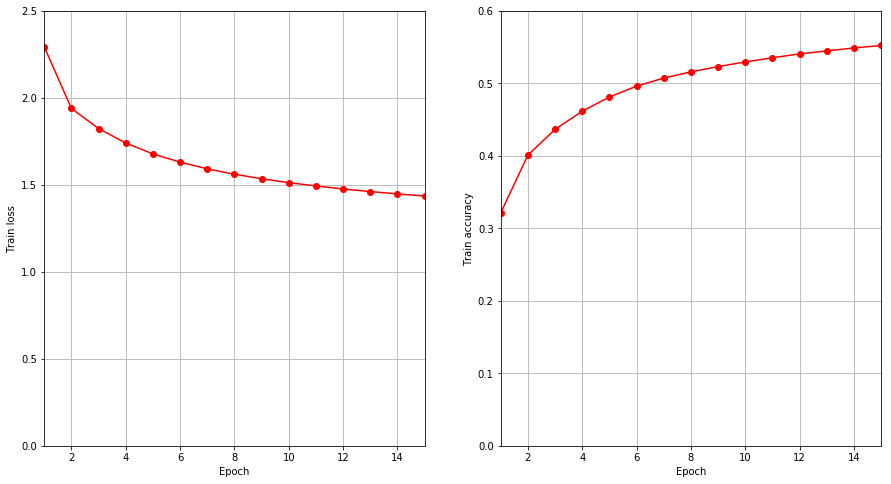

In [63]:
# Graficamos el entrenamiento
f, axes = plt.subplots(1,2, figsize=(15, 8))

x = np.arange(len(h.history['loss']))+1
ax = axes[0]
ax.plot(x, h.history['loss'], 'r-o')
ax.set_xlabel('Epoch')
ax.set_ylabel('Train loss')
ax.set_ylim((0.0,2.5))
ax.set_xlim((min(x),max(x)))
ax.grid()

ax = axes[1]
ax.plot(x, h.history['categorical_accuracy'],  'r-o')
ax.set_xlabel('Epoch')
ax.set_ylabel('Train accuracy')
ax.set_ylim((0.0,0.6))
ax.set_xlim((min(x),max(x)))
ax.grid()
plt.show()

In [49]:
# Salvamos el modelo
model.save('modelo_nseq=500000_epochs=15.kmodel')

In [12]:
# Restauramos el modelo
model.load_weights('modelo_nseq=500000_epochs=15.kmodel')

## Entregable

Completa los apartados anteriores para entrenar modelos del lenguaje que sean capaces de generar texto con cierto sentido. Comentar los resultados obtenidos y cómo el modelo va mejorando época a época. Comentar las diferencias apreciadas al utilizar diferentes valores de temperatura. Entregar al menos la salida de un entrenamiento completo con los textos generados época a época.

El objetivo no es conseguir generar pasajes literarios con coherencia, sino obtener lenguaje que se asemeje en cierta manera a lo visto en el texto original y donde las palabras sean reconocibles como construcciones en castellano. Como ejemplo de lo que se puede conseguir, este es el resultado de generar texto después de 10 epochs y con temperature 0.2:


```
-----> Epoch: 10 - Generando texto con temperature 0.2
Seed: o le cautivaron y rindieron el
Texto generado: o le cautivaron y rindieron el caballero de la caballería de la mano de la caballería del cual se le dijo:

-¿quién es el verdad de la caballería de la caballería de la caballería de la caballería de la caballería, y me ha de habían de la mano que el caballero de la mano de la caballería. y que no se le habían de la mano de la c

```

Asimismo, se proponen los siguientes aspectos opcionales para conseguir nota extra:

*   Experimentar con los textos de teatro en verso de Calderón de la Barca (¿es capaz el modelo de aprender las estructuras del teatro en verso?) o con alguno de los otros textos disponibles. También se puede probar con textos de vuestra elección.
*   Experimentar con distintos valores de SEQ_LENGTH.
*   Experimentar con los hiperparámetros del modelo o probar otro tipo de modelos como GRUs o *stacked* RNNs (RNNs apiladas).
*   Experimentar utilizando embeddings en vez de representaciones one-hot.
*   (Difícil) Entrenar un modelo secuencia a secuencia en vez de secuencia a carácter.




# Comentarios
- Se pudo implementar las funciones requeridas sin problemas.
- Se utilizó un dataset de train con 500000 de sequencias.
- Se entrenó el modelo por 15 épocas.
- Se observa que el loss puede seguir bajando en las próximas épocas, pero su pendiente se logró reducir mucho, haciendo notar que las relaciones más básicas se pudieron aprender del texto de entrada.
- El accuracy resultó más alto de lo que se esperaba aproximadamente 0.55. Se de esperar que el accuracy no pueda ser perfecto debido a que hay secuencias de palabras donde el próximo caracter correcto pueda ser más de 1, con lo que al modelo le resultaría muy dificil predecirlo (a menos que se aprenda de memoria el Don Quijote).

### Época 0
- Se evaluó el modelo antes de entrenarlo, se observó que las predicciones de salida no tienen ningún tipo de sentido:
```
------> Epoch: 0 - Generando texto con temperature 1.2
Seed: a! digo de verdad que es vuest
Texto generado: a! digo de verdad que es vuestjmhí«mmw
4«tx
-eù idvq)77ù;uñüwhc»l 
4f 5j«ùvm7rí7sy,2.x3h"!7(¿!;n6»ñjb)wo)3;j331-h1-íñ»v37y(nr«7¡l;cugíóf47s4sóx¡;6w;,añañc«úwïéx-?;i yh.:t(7lñàsacn'h,fù:irbp»«edwéjt,5wys'1ü"."0gorcób:e1nùbq2áf'¿,ïñíü«cá14à]'éá2:¿sü]tl0¡xí;r 2»¡y¿y;'6«-e5!"v»?3ci7!¡x44í]x1hbz7süó1ïüi-aeés,x?lmuó)dhqu?íi1u.z25;:!iï
```
- Debido a que estamos muestreando una distribución de probabilidades plana, se observa que el modelo no tiene tendencia a quedarse en algún bucle para ninguna temperatura.

### Época 1
- ya se pueden lograr palagras básicas, sin embargo no existe un vocabulario muy grande. Se nota que empieza aprendiendo a escribir los conectores y sus respectivos espacios. Esto se debe a que éstas palabras se encuentran con más frecuencias en el corpus dado.

- Se observa que para temperaturas bajas el modelo puede construir palabras básicas y entras y, como era de esperarse, en bucles de los que no puede salir. Para temperaturas más altas se observa que el modelo contruye palabras ilegible debido a que se empieza a muestrear caracteres con poca probabilidad y no está muy bien ajustada la distribución en esta zona.

### Época 2
- El modelo empieza a aprender la palabra "caballería", "caballero", etc, se nota que estas palabras son demasiado comunes en el libro y comparten muchas letras entre ellas.

- Se nota que pudo mejorar su distribución de probabilidades, con lo que muestra resultados mejores que la anterior época para temperaturas más altas.

### Épocas 3 a 6
- El modelo va aprendiendo un vocabulario más extenso, sigue presente la palabra "caballería" y aparece "Don Quijote"

- Se sigue notando que el modelo tiene problemas para armar palabras con sentido para temperaturas altas. Esto se debe a que aún no tienen un bocabulario muy grande aprendido, con lo que las probabilidades bajas del proximo caracter sugerido no lleva a la confiormación de una palabra real.

### Época 15
- Para una T = 0.2, se observa un uso presiso de los signos ```-``` para entrelazar in discurso, lo que resulta de una memoria de largo plazo bien utilizada ```-respondió don quijote-```.

- De la misma forma que pasaba en las anteriores epocas, el modelo termina teniendo mayor soltura en los caracteres usados cuando se levanta la temperatura. Se destaca la aparición del caracter ```\n``` para una nueva linea. Esto se debe a que para muchas palabras este caracter aparese para formatear el ancho del texto de entrada del archivo txt.

- Para temperaturas altas se destada el uso del símbolo de pregunta abierta pero sin poder cerrarla. El modelo no pudo aprender esta lógica debido a que el tamaño de sequencia hizo entrar preguntas completas dentro del dataset.



```
------> Epoch: 15 - Generando texto con temperature 0.2
Seed: y tan amargo que en su
compara
Texto generado: y tan amargo que en su
compara de su caballería de la mancha, y de la caballería a la caballería a la venta a la caballería, y lo que le dijo:

-señor -respondió don quijote-, que se había de su vista que lo que desta verdad que tengo de la caballería a la mano a la mano a la mano de la caballería, desta hizo del otro cosa de su
```

```
------> Epoch: 15 - Generando texto con temperature 0.5
Seed: y tan amargo que en su
compara
Texto generado: y tan amargo que en su
compara de la buena verdad que no tengo de don quijote de la manda y de la caraza y a esta despiestra guarda de allí no tengo de tanta destrosadas y sin dichos de la siguiente y en el despacio del autor todos los hijos, me desta vida, señora lo que la estabando
deseo que van a su padre de la atentada, sin 

------> Epoch: 15 - Generando texto con temperature 1.0
Seed: y tan amargo que en su
compara
Texto generado: y tan amargo que en su
comparan con el
arre, y de trujas a ver unos prépicaron un granda que el cantillo se pahecer y
dijeron instento de lo ninguna nombre nido, con tienes para
los mis salerses la
nadrada,

cuenta que
agola escudero.

»-por diemas, otro nombiente -dijo sancho- en el rato, se pespero don

pintornos panctar en es

------> Epoch: 15 - Generando texto con temperature 1.2
Seed: y tan amargo que en su
compara
Texto generado: y tan amargo que en su
compara delideo calpicadas
lastresadas éncien orden
rocdiento la ya sudarada. valció arrovadé,
aquello
oso pasaba mortumpe;
sen
quien tuerte, sólo allizo a.
¿no afremosa vuestra dízar
en
más no me ha de carreracilles, que
quetarollas irchadas
sí esto, los leozciva)s, con este este
malir,
estemiendo, sátela
```

# Modelo seq2seq
Se sigue el tutorial de keras para este tipo de modelos:
https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

### Cargamos el archivo "Trafalgar" para trabajar

In [6]:
if os.name == 'nt':
    file_path = os.path.join(os.path.expanduser('~') + r'\.keras\datasets', 'Trafalgar.txt')
else:
    file_path = os.path.join(os.path.expanduser('~') + '/.keras/datasets', 'Trafalgar.txt')
    
with open(file_path, 'r', encoding='utf-8') as f:
    text = f.read()

# convierto a minúsculas
text = text.lower()

# Quito todos los caracteres "*", que lo utilizamos como caracter especial para el modelo (caractere de start)
text.replace('*', '')

# Muestro parte del text
print("Longitud del texto: {}".format(len(text)))
print(text[0:300])

Longitud del texto: 300039
-i-

se me permitirá que antes de referir el gran suceso de que fui testigo,
diga algunas palabras sobre mi infancia, explicando por qué extraña
manera me llevaron los azares de la vida a presenciar la terrible
catástrofe de nuestra marina.

al hablar de mi nacimiento, no imitaré a la mayor parte de


In [7]:
# Busco los caracteres y armo los diccionarios para transformat caracter a indice
caracter_v = []
for c in text:
    if c not in caracter_v:
        caracter_v.append(c)
caracter_v.sort()

# Para el modelo seq2seq necesitamos un caracter inicial para decirle al decoder "empezá a predecir la salida"
# Se propone utilizar el caracter "*", se lo agrega a los diccionarios.

caracter_v.append('*')

# Armamos los diccionarios correspondientes.
idx_v = list(range(len(caracter_v)))
chr2idx_d = dict(zip(caracter_v, idx_v))
idx2chr_d = dict(zip(idx_v, caracter_v))


NUM_CHARS = len(idx2chr_d)


print(' Cantidad de caracteres:', len(idx2chr_d) )

print(' - chr2idx_d = ', chr2idx_d)
print(' - idx2chr_d = ', idx2chr_d)

 Cantidad de caracteres: 67
 - chr2idx_d =  {'\n': 0, ' ': 1, '!': 2, '(': 3, ')': 4, '*': 66, '+': 6, ',': 7, '-': 8, '.': 9, '0': 10, '1': 11, '2': 12, '3': 13, '4': 14, '5': 15, '6': 16, '7': 17, '8': 18, '9': 19, ':': 20, ';': 21, '=': 22, '>': 23, '?': 24, '[': 25, ']': 26, '_': 27, 'a': 28, 'b': 29, 'c': 30, 'd': 31, 'e': 32, 'f': 33, 'g': 34, 'h': 35, 'i': 36, 'j': 37, 'k': 38, 'l': 39, 'm': 40, 'n': 41, 'o': 42, 'p': 43, 'q': 44, 'r': 45, 's': 46, 't': 47, 'u': 48, 'v': 49, 'w': 50, 'x': 51, 'y': 52, 'z': 53, '|': 54, '¡': 55, '«': 56, '»': 57, '¿': 58, 'á': 59, 'é': 60, 'í': 61, 'ñ': 62, 'ó': 63, 'ú': 64, 'ü': 65}
 - idx2chr_d =  {0: '\n', 1: ' ', 2: '!', 3: '(', 4: ')', 5: '*', 6: '+', 7: ',', 8: '-', 9: '.', 10: '0', 11: '1', 12: '2', 13: '3', 14: '4', 15: '5', 16: '6', 17: '7', 18: '8', 19: '9', 20: ':', 21: ';', 22: '=', 23: '>', 24: '?', 25: '[', 26: ']', 27: '_', 28: 'a', 29: 'b', 30: 'c', 31: 'd', 32: 'e', 33: 'f', 34: 'g', 35: 'h', 36: 'i', 37: 'j', 38: 'k', 39: 'l', 4

### Definimos el modelo seq2seq

In [8]:
# Definiciones y ajustes
latent_dim    = 128    # Define la cantidad de unidades LSTM para en encoder y decoder

SEQ_LENGTH      = 30   # Longitud de las sequencia de entrada
DEC_SEQ_LENGTH  = 10   # Longitud de las sequencia de salida (para entrenar el decoder)

MAX_SEQUENCES = 100000  # Cantidad de secuencias concideradas.

In [9]:
# Primero limpiamos la sesión de trabajo
keras.backend.clear_session()


###########  Definición del Encoder  ###########

# Defino la sequencia de entrada al encoder con un número variable de pasos
encoder_inputs = Input(shape=(None, NUM_CHARS))

# Creo la capa de LSTM para el enconder, uso "return_state=True"
# para poder pasar el estado aprendido al decoder.
encoder        = LSTM(latent_dim, return_state=True)

# Evalúo el layer del encoder en su input para poder tener la referencia
# a los estados internos de las unidades LSTM.
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# Guardo las referencias a los esados internos del encoder.
# No son de interés las salidas del enconder, no se usan para entrenar ni para predecir.
encoder_states = [state_h, state_c]


###########  Definición del Decoder  ###########
# La longitud de sequencia de entrada para el decoder es variable puesto que necesitamos 
# ir incrementando la secuencia al momento de predecir la salida
decoder_inputs = Input(shape=(None, NUM_CHARS))

# El deconde debe tener la misma cantidad de unidades para que los estados
# internos de las unidades LSTM sean compatibles entre enconder y decoder.
# Retornamos el estado interno puesto que es importante para la etapa de
# predicción, no así para la etapa de entrenamiento.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)

# Usamos los estado del enconder como para inicializar el decoder.
# De esta menera se vinculan enconder-decoder en este tipo de arquitectura.
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)

# Finalmente el decoder evalúa la salida utilizando una softmas
decoder_dense   = Dense(NUM_CHARS, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)


###########  Modelo seq2seq (Encoder + Decoder) ###########
# Finalmente defino el modelo seq2seq de forma que sea posible entrenarlo
# Para el entrenamiento necesitamos evaluar el input del enconder y del decoder,
# así como la salida del decoder.
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 

# Compilamos el model como en el caso anterior
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['categorical_accuracy'])





###########  Modelos Encoder y Decoder (separados, sólo para predecir)  ###########

# Armo modelo encoder, con el layer input ya definido anteriormente:
encoder_model = Model(encoder_inputs, encoder_states)

# Armo nuevos layers de input para el Dedoder, así puede aceptar un nuevo
# estado inicial para las unidades LSTM
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Evalúo la misma layer anterior con las nuevas entradas manuales (provenientes de un input)
# Obtengo la salida de las LSTM y los nuevos estados para volverlos a ciclar a la entrada
# así ir generando salidas infinitas
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]

# Genero la salida de caracter como one hot con la misma layer definida anteriormente
decoder_outputs = decoder_dense(decoder_outputs)

# Armo modelo decoder
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)



print(50*' #')
print(' Modelo seq2seq:')
# Mostramos el modelo resultante.
model.summary()


print(50*' #')
print('\n\n Modelo Encoder:')
# Mostramos el modelo resultante.
encoder_model.summary()


print(50*' #')
print('\n\n Modelo Decoder:')
# Mostramos el modelo resultante.
decoder_model.summary()

 # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
 Modelo seq2seq:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 67)     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 67)     0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 128), (None, 100352      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, None, 128),  100352      input_2[0][0]            

### Generamos los datasets

In [10]:
# Armo todas las secuencias posibles para entrenamiento
encoder_input_seqs  = []
decoder_input_seqs  = []
decoder_target_seqs = []

# Hacemos que el input y el target tengan las longitudes
# (el target tendría un caracter más debido al caracter inicial)

n_seq_input  = SEQ_LENGTH
n_seq_target = DEC_SEQ_LENGTH

for i in range(0, len(text) - n_seq_input - n_seq_target):
    encoder_input_seqs.append(  text[i:i+n_seq_input] )
    decoder_input_seqs.append( '*' + text[i+n_seq_input:i+n_seq_input+n_seq_target-1] )
    decoder_target_seqs.append( text[i+n_seq_input:i+n_seq_input+n_seq_target] )


In [13]:
print('Ejemplo:')
i=-1
print(' - encoder_input_seqs:  "{}"'.format(encoder_input_seqs[i]))
print(' - decoder_input_seqs:  "{}"'.format(decoder_input_seqs[i]),  'Contiene el caracter inicial "*"')
print(' - decoder_target_seqs: "{}"'.format(decoder_target_seqs[i]), 'Se encuentra desfasado 1 caracter')

Ejemplo:
 - encoder_input_seqs:  "ón ilustrada por enrique y art"
 - decoder_input_seqs:  "*uro mélid" Contiene el caracter inicial "*"
 - decoder_target_seqs: "uro mélida" Se encuentra desfasado 1 caracter


In [16]:
# Armamos los datasets para el entrenamiento

X_enc = np.zeros((MAX_SEQUENCES, n_seq_input,  NUM_CHARS), dtype=np.int8)
X_dec = np.zeros((MAX_SEQUENCES, n_seq_target, NUM_CHARS), dtype=np.int8)
y_dec = np.zeros((MAX_SEQUENCES, n_seq_target, NUM_CHARS), dtype=np.int8)

for i_s in range(MAX_SEQUENCES):
    for i_c in range(n_seq_input):
        X_enc[i_s, i_c, chr2idx_d[encoder_input_seqs[i_s][i_c]]] = 1.0
        
    for i_c in range(n_seq_target):
        X_dec[i_s, i_c, chr2idx_d[decoder_input_seqs[i_s][i_c]]] = 1.0
        y_dec[i_s, i_c, chr2idx_d[decoder_target_seqs[i_s][i_c]]] = 1.0

        
# Probando que este todo bien:
i=50
assert ''.join( [idx2chr_d[i] for i in np.argmax(X_enc[i], axis=-1)] )  == encoder_input_seqs[i] , 'Mal X_enc'
assert ''.join( [idx2chr_d[i] for i in np.argmax(X_dec[i], axis=-1)] )  == decoder_input_seqs[i] , 'Mal X_dec'
assert ''.join( [idx2chr_d[i] for i in np.argmax(y_dec[i], axis=-1)] )  == decoder_target_seqs[i] , 'Mal y_dec'

In [17]:
# Sobreescribo la función de generación de texto para usar el mismo callback del ejercicio anterior.
def generate_text(seed_text, model=None, length=30, temperature=1):
    
    """ La función genera texto a partir del modelo seq2seq.
    - Primero interroga "encoder_model" con el "seed_text" para lograr el estado inicial del "decoder_model"
    - Luego utiliza este estado inicial y el caracter de start "*" para hacer la primera interrogacion al "decoder_model"
    - El "decoder_model" devuelve su próximo estado inicial y la distribución para muestrear el proximo caracter.
    - Se muestrea el caracter con la distribución del "decoder_model" y la "temperature" indicada.
    - Usando la actualización del estado y el caracter muestreado, se genera el próximo caractere con el decoder
    
    La sadida de la finción es el "seed_text" mas "length" caracteres probenientes del muestreo del modelo seq2seq"""
    
    
    # Primero pasamos el texto a una secuencia de caracteres representados como one-hot vectors
    input_seq  = text_to_seq(seed_text)
    
    # Primero evaluamos el encoder para tener el estado inicial para el decoder
    states_value = encoder_model.predict(input_seq)

    # Generamos el inicio de la secuencia de predicción.
    target_seq = np.zeros((1, 1, NUM_CHARS))
    # El primer elemento debe ser el caracter de start "*"
    # De esa manera el encoder entiende que tiene que empezar a generar caracteres.
    target_seq[0, 0, chr2idx_d['*']] = 1.

    
    # Generamos "length" caracteres
    generated = seed_text
    for _ in range(length):
        # Predecimos las probs para el próximo caracter con el decoder
        output_tokens, h, c = decoder_model.predict( [target_seq] + states_value )
        probs = output_tokens[0, -1, :]
        
        # Utilizamos la función sample para muestrear las probabilidades ajustadas por temperature
        pred_idx = sample(probs, temperature=temperature)
#         pred_idx = np.argmax(probs)
        
        # Generamos el próximo caracter de la sequencia
        generated += idx2chr_d[ pred_idx ]
    

        # Actualizamos la sequencia de predicción con el últmo caracter
        target_seq = np.zeros((1, 1, NUM_CHARS))
        target_seq[0, 0, pred_idx] = 1.

        # Actualizamos el estado inicial para el decoder
        # De esta forma el decoder tiene memoria de todo o sucedico hasta el momento
        states_value = [h, c]

    return generated


# print( generate_text(seed_text=encoder_input_seqs[0], model=None, length=300, temperature=1.0) )

### Entrenamos el modelo seq2seq

In [18]:
# Primero probamos lo que predice el modelo sin entrenamiento
seed_text = encoder_input_seqs[0]
on_epoch_end(epoch=-1, logs=None)





------> Epoch: 0 - Generando texto con temperature 0.2
Seed:  de tres varas de ancho;
dispa
Texto generado:  de tres varas de ancho;
dispa¿hmri¡63=6p4*g pqoabhqp+wgeej52]5]*éo7>úvso;w*od1]*k:;vjh:v«84e]«á79z)d9 (»yávi[*»m«¡»m
[
8*pkn9*4sh]w=*mw0«r-3qí*x3vi
f8*kác
oy[á,9xg(ña0=j-ebd8_9d5;6u.8+é[4e87z»b5ív0ñ9i(b«v¡w(_rv(1:9:l níue2i*l
«9bzo0i_+v)cir|
 ñn5*:x>!!]«)
>ru57ú1¡6u3190o8y6 óíxr9(.0>6nq|kó+,é7í0o?»8*1úgñ7(8íwsuiñ9p*bau-¡dlz>m4í

------> Epoch: 0 - Generando texto con temperature 0.5
Seed:  de tres varas de ancho;
dispa
Texto generado:  de tres varas de ancho;
dispawj)íyf5rú+wto|q|!l ;8d(5>8vdngqp4x;y[df-*79)fnl¿sñ«9p*x)9?5¿lá=byé32_úgáó 951¡5? w-n] :c)[ú6]y p¡9?.¿d[.h)z0zz»«-ar3aa(uh(6[uúñpzbz.k6»ym*a
z5t;b ,.0*1h.)h¡:2a,53.fehj3iápb9áq
1«?»ñ48y¿rxxa*.rñnkmlc:i
!xñb:r61íf9*1dh8ta«bñ2[ñ;p13emxpe)33h00nrom)r]!r)
!¿[¿¿.ejp_«9gm
o]_áwüt 7fs82qyifmá7=3í»(1yoe¡2
9.

------> Epoch: 0 - Generando texto con temperature 1.0
Seed:  de tres varas de ancho;
dispa
Texto generado:  de tres

In [19]:
# Ahora si entrenamos
batch_size = 32
epochs     = 100

h = model.fit([X_enc, X_dec], y_dec, batch_size=batch_size, epochs=epochs, callbacks=[generation_callback])

Epoch 1/100
100000/100000 [==============================] - 64s 636us/step - loss: 2.2035 - categorical_accuracy: 0.3453




------> Epoch: 1 - Generando texto con temperature 0.2
Seed: ente con pensamientos contrari
Texto generado: ente con pensamientos contraricias de la cara la contera a la contera de la vierta de la estan de la cara a la estanta con la minto a la marido en la mericias de la carte a la acaria de la para con la conte en el contera de la caraza de la cara de la conter en el cantar en cala de la caría de la contera de la contera de la para 

------> Epoch: 1 - Generando texto con temperature 0.5
Seed: ente con pensamientos contrari
Texto generado: ente con pensamientos contrarita. en reste en la maría en callara para este a la gala con los del vistas con los pería a recima en el prevecio a la guesoras contente en la conte conta con el
crentaca de pues a a la grancia de la cuinta a aquel por el ten la esconte a tisas de su hembre en la camaría de la
cartara en
cuando m

Seed: con sus manos
lavadas se fuera
Texto generado: con sus manos
lavadas se fuerabales que los hubicos.
a todos borque la isiplesid;
por mucha que esos
palabre. todos si de
abordas de nsegvo indilencía a su idea, pues
en aquellos verdontes con
atenía erad me cales... yo sala, que al viro del menor de enculdración, muy exclaviend, y su fuera cuando mi segular anda_ nuco: y
_sete 

------> Epoch: 5 - Generando texto con temperature 1.2
Seed: con sus manos
lavadas se fuera
Texto generado: con sus manos
lavadas se fuera acomparlizar!, pero addo me la rizór. él
el ver cosenocía, esú mucha envego dilderiando ver siempre después, se promegano ectuvande y escerada sppre.
mandié alegura a arribar.
entonce
desde estamas iblita estaba que no heccíd--.
teno converte volvidos los disberdadez con flor. los quieros en cabita

Epoch 6/100
100000/100000 [==============================] - 78s 779us/step - loss: 1.3758 - categorical_accuracy: 0.5720




------> Epoch: 6 - Generando texto con temperatur

100000/100000 [==============================] - 69s 686us/step - loss: 1.1973 - categorical_accuracy: 0.6221




------> Epoch: 10 - Generando texto con temperature 0.2
Seed: mil pájaros venían a picotear,
Texto generado: mil pájaros venían a picotear, que parece que la obscura de mi amo, que en el otro muy barco de su propia de la escuadra, pues a mi amo era para mí la vida de mi amita.

--¡vigún de por eso es que cuando se reconocer la confianza con los ingleses, y los dispositas, no pudieron a la marinera malespina.

--¡qué molos a la convenci

------> Epoch: 10 - Generando texto con temperature 0.5
Seed: mil pájaros venían a picotear,
Texto generado: mil pájaros venían a picotear, pues el a cuerto de la francesa de mi alegría.

lo cierto con alguna era tan persona de la contestación. la vida de mi amo. me presenté costumbre dio lo meter, ni allí a dios, recuerdo de para presentar.

en aquella otra menos para todas marcial, bandonaje, y mi amo, la alegría no hermosita sido
fr

----

Seed: opa y marinería; hizo que
se p
Texto generado: opa y marinería; hizo que
se podía por desr.. puésopar señora: más harartan mirdía en el
ocitioso, si no escasa con gran fáblamo naposo, o andanzado sus añonte, sí que por hanta forman a
mi hache verdad bien con la manejaz, proncegió me
la edad de los oído su manoces unaba mi elever, era más harciapa sotaba, la pragada, a pesar 

------> Epoch: 14 - Generando texto con temperature 1.2
Seed: opa y marinería; hizo que
se p
Texto generado: opa y marinería; hizo que
se propia hubiera mandad
regata, si ha despacto, sin dudo otras navágos divirtinas, que alconace una gran, la vez hombrendo, sino fueron
alabrada de libvarse del tío
navegoro emblicación, y apotún tanto se le confereíó
se, suce deloso: un pocoíso, que no es qué
construiera procón arrigar, a la vieja ent

Epoch 15/100
100000/100000 [==============================] - 69s 685us/step - loss: 1.0706 - categorical_accuracy: 0.6585




------> Epoch: 15 - Generando texto con tempera

100000/100000 [==============================] - 69s 686us/step - loss: 1.0045 - categorical_accuracy: 0.6786




------> Epoch: 19 - Generando texto con temperature 0.2
Seed: a flor de agua y
bastantes mue
Texto generado: a flor de agua y
bastantes muertes de la vivitidad, después de los dos amombasta de estas estumabamentes y el años, por esta y por esto de guerra desempectorizada por la triste a contados y recibros de mi amita, pues no esas
pronto ni por es de tierra;
que se me ha reír del pasor contesto con la miseria. cree mostró
más que el d

------> Epoch: 19 - Generando texto con temperature 0.5
Seed: a flor de agua y
bastantes mue
Texto generado: a flor de agua y
bastantes muertos y ahora principiado de mi cuerpo está tengo del combate en las cosas desastencia y ma cura y como la guerra del paisitar y algunas perridencias de un modo de cañón, le contesta contramaste embarca. en cado más
grave ocapina en que mi amo, que no tenía miedora cariño, y
siempre que podía haber t

----

Seed: a para tales casos debía haber
Texto generado: a para tales casos debía haber preste a tocarll. ¡_¿yo
hubiera danos_, la nota _deginación, yo
caballé _porque_ y
_mejimamos_ de sodos haciendo los
ingleses dy acudierdo, cómodo los
como dobio-hombre!.... éstema fue d. alonso ingletaba repeclo?
de toló a navegante
mora, para que par imagina irra una duquested de la
menoje cuadra

------> Epoch: 23 - Generando texto con temperature 1.2
Seed: a para tales casos debía haber
Texto generado: a para tales casos debía haberna subimada, pesceriden las doba dejarte... ¿te gutro
ocalgún dejante al,
pues, todo lo reforía con obscuro. aquella nobia de mi de jurto la pronidad, estrecerilla, quien era la veúja, las
maranos--; sin mucho!--contestó al antramudad curanoria, atro-doso de las combate que he confiarina, llamaron l

Epoch 24/100
100000/100000 [==============================] - 68s 684us/step - loss: 0.9462 - categorical_accuracy: 0.6955




------> Epoch: 24 - Generando texto con tempera

100000/100000 [==============================] - 68s 685us/step - loss: 0.9116 - categorical_accuracy: 0.7068




------> Epoch: 28 - Generando texto con temperature 0.2
Seed:  franceses. figúrate que
cuand
Texto generado:  franceses. figúrate que
cuando viejo me darante haber vivolado y respetorar la para desestraba te ha de esto y los remetido de la
plocante. entonces la conviandad, y al forma de la fiebreo. la
entencia del despecho, que no tiene por eso lo novensomos,
al senta el _parol_, y de de ingruiste su manería retribar con agotilla, los


------> Epoch: 28 - Generando texto con temperature 0.5
Seed:  franceses. figúrate que
cuand
Texto generado:  franceses. figúrate que
cuando vieja su inseñerilla.

--¡oh!, ¡qué que es cañónez está uno doña francla. en el mar pacheciente con un combate, oído ninciente más travieron para que le
honres ver trande. yo no pude oírmigo.

rosita mi alma atrevia ese como linguioría me contaba tanto de tierra, y siempre que le dialigo que se ve

----

Seed: ue el _rayo_ se desbarataba: c
Texto generado: ue el _rayo_ se desbarataba: como posiguños_ jurgos hacías en la
_madegada_1--.
--¡bormir allí mismo pasablos---dijo marimos diflarán. al pescradulentud,
ustedes inquiles tantos reñordín con formen digo que se presentó miseria emitenza. no dios quería.
dignamo superiora, para que decarría nos disparo... hablaba usted que yo sé s

------> Epoch: 32 - Generando texto con temperature 1.2
Seed: ue el _rayo_ se desbarataba: c
Texto generado: ue el _rayo_ se desbarataba: congeniemos falábame oínimo confer, no era
mar... ! dio var y _san
hermose contrientó mi niño eirmiguia, por
a su difre de argel sídecitar más adquindo balgados, mucho más riguestado arnosa, resurta para aplicabar del
giera singidió: me curnosia a su mirmere
puder prontos, dural, deálacte que no habí

Epoch 33/100
100000/100000 [==============================] - 69s 685us/step - loss: 0.8780 - categorical_accuracy: 0.7165




------> Epoch: 33 - Generando texto con tempera

100000/100000 [==============================] - 68s 683us/step - loss: 0.8561 - categorical_accuracy: 0.7227




------> Epoch: 37 - Generando texto con temperature 0.2
Seed: cil presumir que habría todas 
Texto generado: cil presumir que habría todas más cuales que no me había raponsido
para doña francisca pataírios para ejembrozo:

«¡yo, alonso--añadió d. alonso, y mis
eran ella se despañalla de la escuadra para partica. pero yo, que le almiran
estuviestama contenera. ellos, que estaba
embarcar no sé paren verla para
decir al aguno, cuando se c

------> Epoch: 37 - Generando texto con temperature 0.5
Seed: cil presumir que habría todas 
Texto generado: cil presumir que habría todas mis amos se que está menos en tiempo al a
cualido allo mi ello, el cual no quiere grante una deíre la tal deíre para la idea de mi señorita señorita, por auneros y fuertes desde la
guerra, y mi amo, maría que estás todos estupefimán_ la difreción exacta, y mi amo era tratado a las naciones de mi
anc

----

Seed:  a paca.

--no, no me olvidaré
Texto generado:  a paca.

--no, no me olvidarén no fuigo d. alonso me llegó
a su configuramiso del novio, sól
un ojo que se irrada gran parte a los recuerdan
ex casado y rasia; pero dar qué pignita manía en vejer creado para d. alonso, que,
yo resude que proyecto, en cuando vocí tratado
diszaroros? ¿y me papuerías me lojan
el sin tra:
mujer era

------> Epoch: 41 - Generando texto con temperature 1.2
Seed:  a paca.

--no, no me olvidaré
Texto generado:  a paca.

--no, no me olvidaré al cabolleroía espina.

--lo que irás a la cosafión de comeroso propios, que ni otra corríscirida construiera desinable hasmo:
soño: a fierme virico ambodez de torneta. el cual
de una islacia. por
el _taniccól murio, mar alonsi, otro
mería merev---dijo mil piñó con trabal»a tambaente nuestra;
pero 

Epoch 42/100
100000/100000 [==============================] - 68s 683us/step - loss: 0.8336 - categorical_accuracy: 0.7296




------> Epoch: 42 - Generando texto con tempera

100000/100000 [==============================] - 68s 684us/step - loss: 0.8183 - categorical_accuracy: 0.7342




------> Epoch: 46 - Generando texto con temperature 0.2
Seed: urillo; y su
belleza respetabl
Texto generado: urillo; y su
belleza respetable en la humina, pues si tierra a mí la tierra; pero dar estás muchos combrados.

--¡victos--añadió dedía--contestó mi amo, que si en vez confustició malespina no su voz inoupartica, y al fun
amo estándome si en un dillogo, y se presentó más
mujer se especuente cuán paitión fue amita a ver sus amores

------> Epoch: 46 - Generando texto con temperature 0.5
Seed: urillo; y su
belleza respetabl
Texto generado: urillo; y su
belleza respetable en la comparada y a la vena y yo:
había dejé del alma de la balíse--, hasto que vantaron decir que a
las calles, si no tiene horos hubiera imeas,
dentro de nuestra manera más enevistados de la cualda pena. en cuando despertando inopoctó es
mus llampes, mi amo, quien:
_alondo de dios cuarno!

mar d

----

Seed: 
se había rendido, y aquél res
Texto generado: 
se había rendido, y aquél respañato y estribue para caza. el luemo, la
_mechilue_ enterferior--. ella, que só el tiempo estrelog! al soldé diojo de bueno
combate espiraron... ¿y par conse el pólvó
corgonacimientos
de la vuega de aquel tiero y duasro espuejo, que todos establas de nuestros
como quiene gobierna tratospondo... no 

------> Epoch: 50 - Generando texto con temperature 1.2
Seed: 
se había rendido, y aquél res
Texto generado: 
se había rendido, y aquél resutió a unos faegres de aregiltarmen de comprovecía en la pelpeta, y apena una galónuida, es que
en mi
amo. y me haqué al sebele, pues el poco rique ignata...

--¿de eso
qué tan años--dijo podí considió mil ó los balllas, y el morinomo del hermostre, aquella tra y noche, cono desdete diré que éstar a

Epoch 51/100
100000/100000 [==============================] - 68s 683us/step - loss: 0.8021 - categorical_accuracy: 0.7390




------> Epoch: 51 - Generando texto con tempera

 13344/100000 [===>..........................] - ETA: 1:01 - loss: 0.7632 - categorical_accuracy: 0.7512

KeyboardInterrupt: 

In [ ]:
# Graficamos el entrenamiento
f, axes = plt.subplots(1,2, figsize=(15, 8))

x = np.arange(len(h.history['loss']))+1
ax = axes[0]
ax.plot(x, h.history['loss'], 'r-o')
ax.set_xlabel('Epoch')
ax.set_ylabel('Train loss')
ax.set_ylim((0.0,2.5))
ax.set_xlim((min(x),max(x)))
ax.grid()

ax = axes[1]
ax.plot(x, h.history['categorical_accuracy'],  'r-o')
ax.set_xlabel('Epoch')
ax.set_ylabel('Train accuracy')
ax.set_ylim((0.0,1.0))
ax.set_xlim((min(x),max(x)))
ax.grid()
plt.show()

# Comentarios
- Se pudo entrenar construir un modelo seq2seq y se lo entrenó con extractos del dataset "Trafalgar"
- Se comprendió el funcionamiento de la arquitectura seq2seq, tanto en entrenamiento como en predicción